### Czynniki wpływające na wynik APGAR
## W tym notebooku przeanalizujemy zbiór urodzeń dzieci w USA z 2020 i postaramy się wywnioskować co i w jaki sposób wpływa na końcowy wynik APGAR
### Zaczniemy od instalacji odpowiednich bibliotek

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install sklearn

### Zaimport|ujmy wszystkie używane biblioteki

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, f1_score

### Wczytajmy teraz dane i sprawdźmy jak się prezentują

In [3]:
df = pd.read_csv('../natality_dataset.csv')
df.head()

,Mothers Single Years of Age,Mothers Age Recode 9,Cigarettes Before Pregnancy,Cigarettes 1st Trimester,Cigarettes 2nd Trimester,Cigarettes 3rd Trimester,Body Mass Index,Body Mass Index Recode,No Risk Factors Reported,No Infections Reported,Five Minute APGAR Score,Five Minute APGAR Recode
0,25,4,0,0,0,0,26.5,3,1,1,8,3
1,28,4,0,0,0,0,24.0,2,0,1,10,4
2,36,6,0,0,0,0,31.6,4,1,1,9,4
3,32,5,0,0,0,0,24.0,2,1,1,9,4
4,39,6,0,0,0,0,23.8,2,0,0,9,4


In [4]:
df.shape

(100000, 12)

In [5]:
df.columns

Index(['Mothers Single Years of Age', 'Mothers Age Recode 9',
       'Cigarettes Before Pregnancy', 'Cigarettes 1st Trimester',
       'Cigarettes 2nd Trimester', 'Cigarettes 3rd Trimester',
       'Body Mass Index', 'Body Mass Index Recode', 'No Risk Factors Reported',
       'No Infections Reported', 'Five Minute APGAR Score',
       'Five Minute APGAR Recode'],
      dtype='object')

### EDA
Przeanalizujmy z jakim zestawem danych przyszło nam pracować

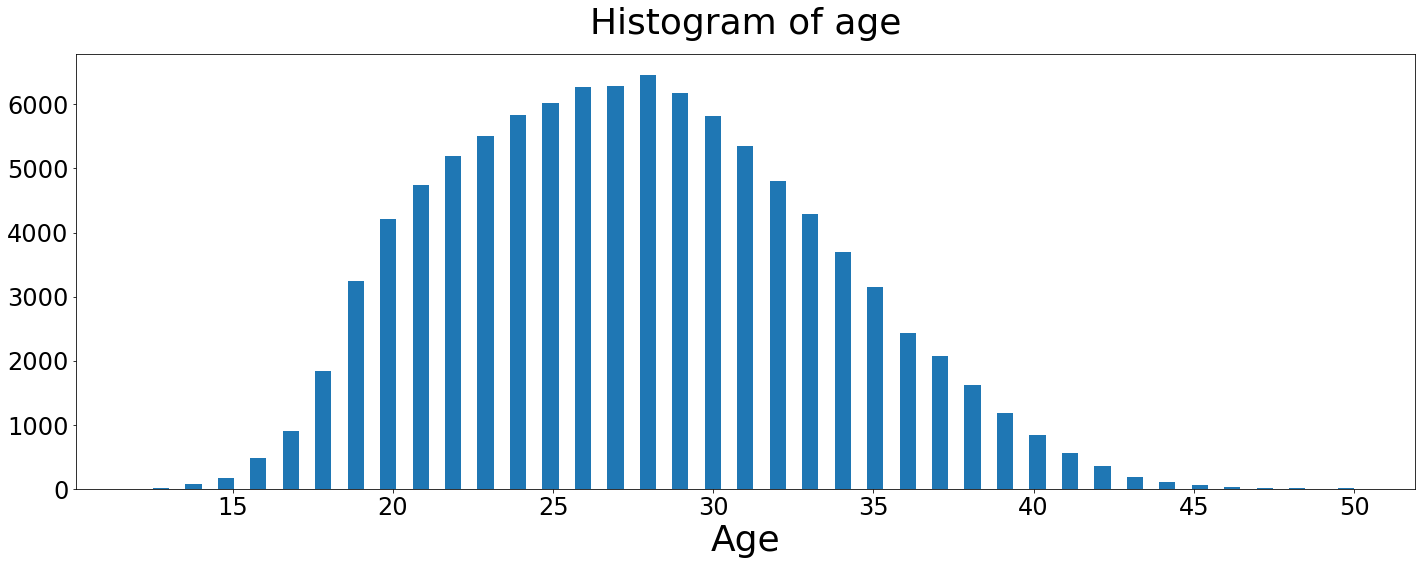

In [6]:
plt.figure(figsize=(24, 8))
plt.title("Histogram of age", fontsize=36, pad=20)
plt.xlabel('Age', fontsize=36)
plt.hist(df['Mothers Single Years of Age'], bins=75)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

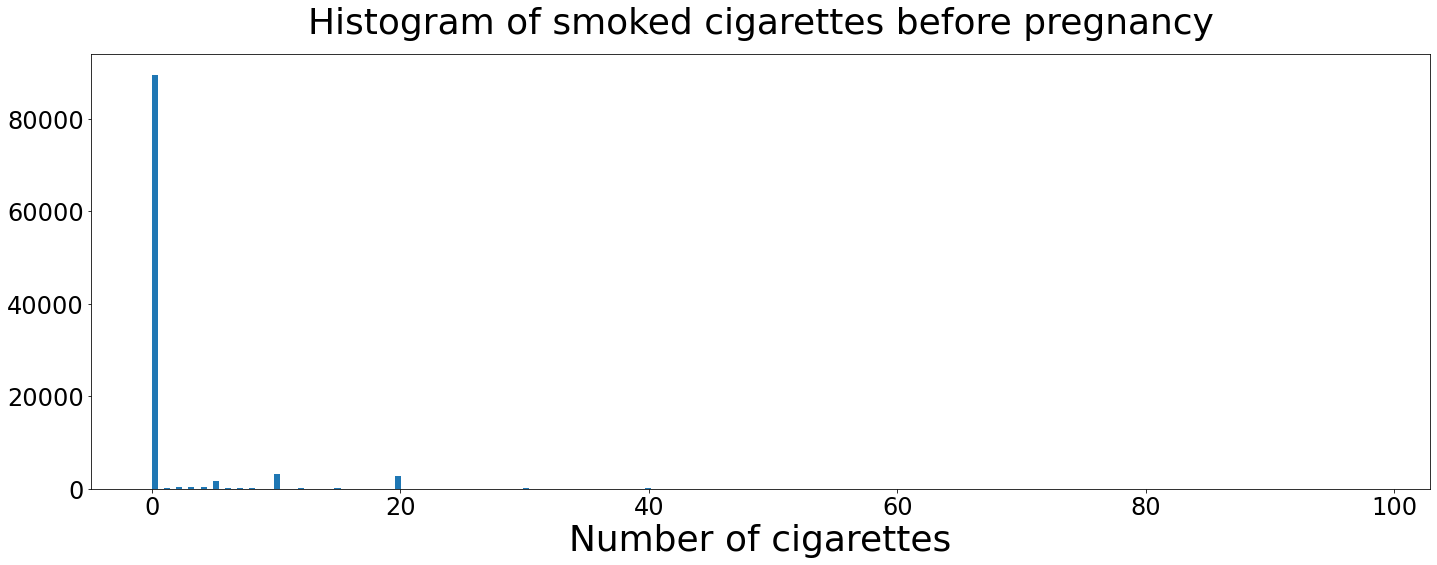

In [7]:
plt.figure(figsize=(24, 8))
plt.title("Histogram of smoked cigarettes before pregnancy", fontsize=36, pad=20)
plt.xlabel('Number of cigarettes', fontsize=36)
plt.hist(df['Cigarettes Before Pregnancy'], bins=200)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

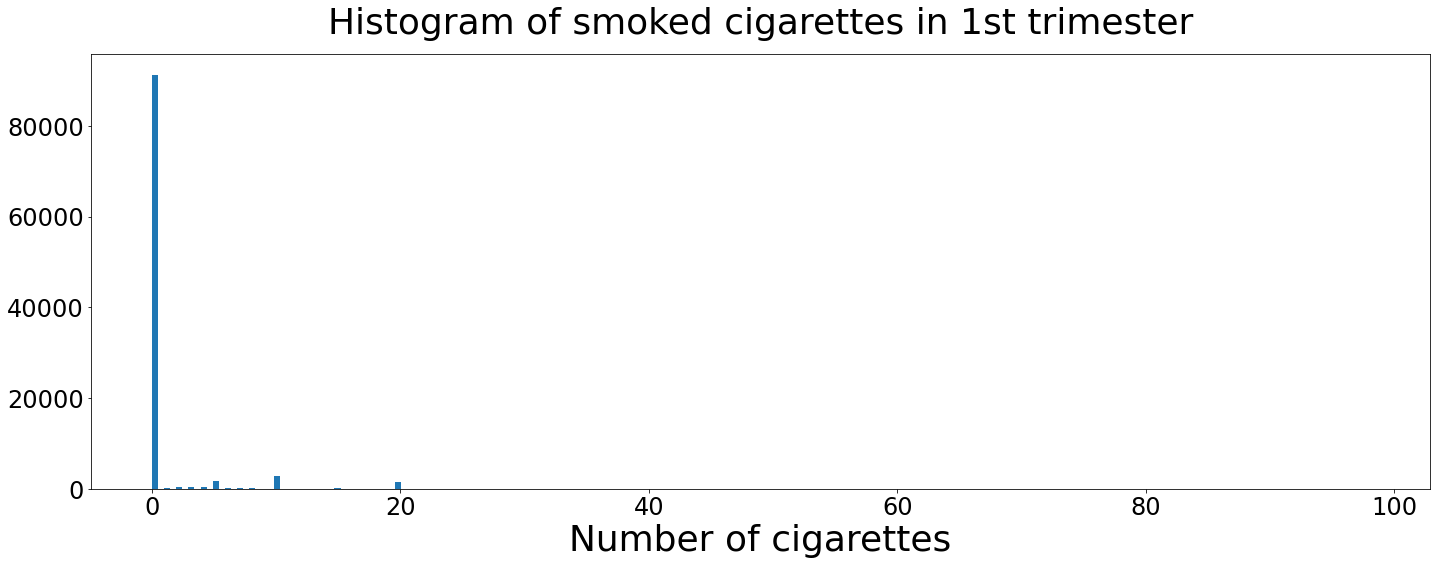

In [8]:
plt.figure(figsize=(24, 8))
plt.title("Histogram of smoked cigarettes in 1st trimester", fontsize=36, pad=20)
plt.xlabel('Number of cigarettes', fontsize=36)
plt.hist(df['Cigarettes 1st Trimester'], bins=200)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

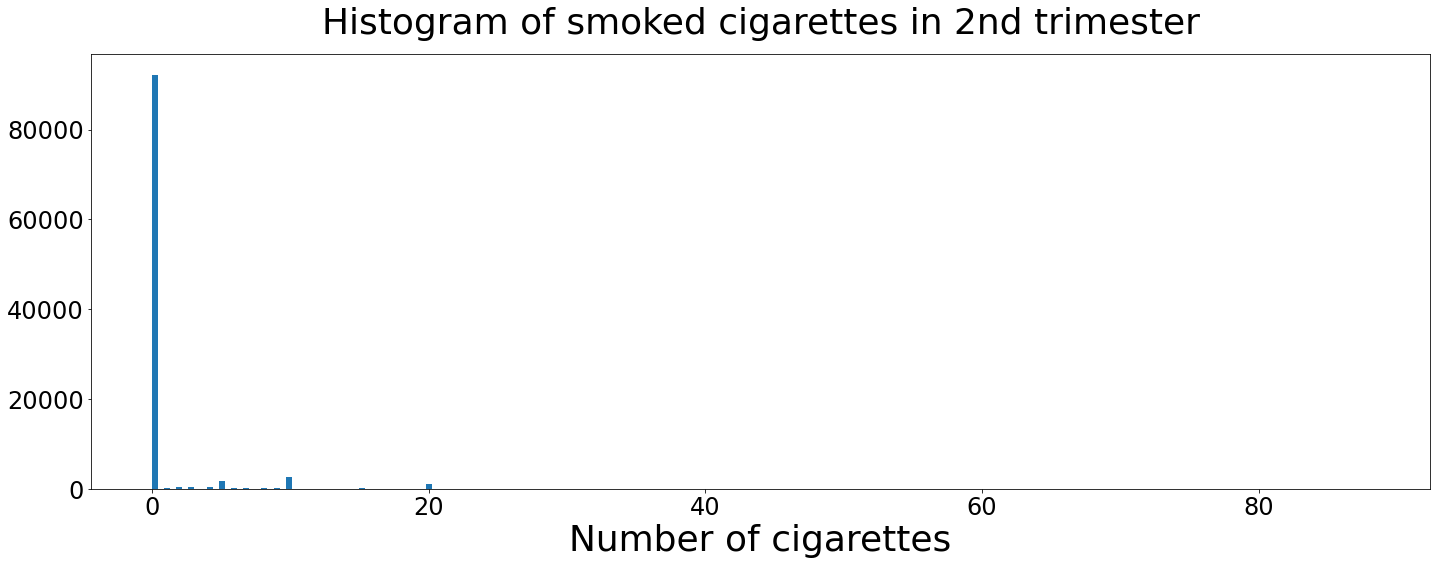

In [9]:
plt.figure(figsize=(24, 8))
plt.title("Histogram of smoked cigarettes in 2nd trimester", fontsize=36, pad=20)
plt.xlabel('Number of cigarettes', fontsize=36)
plt.hist(df['Cigarettes 2nd Trimester'], bins=200)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

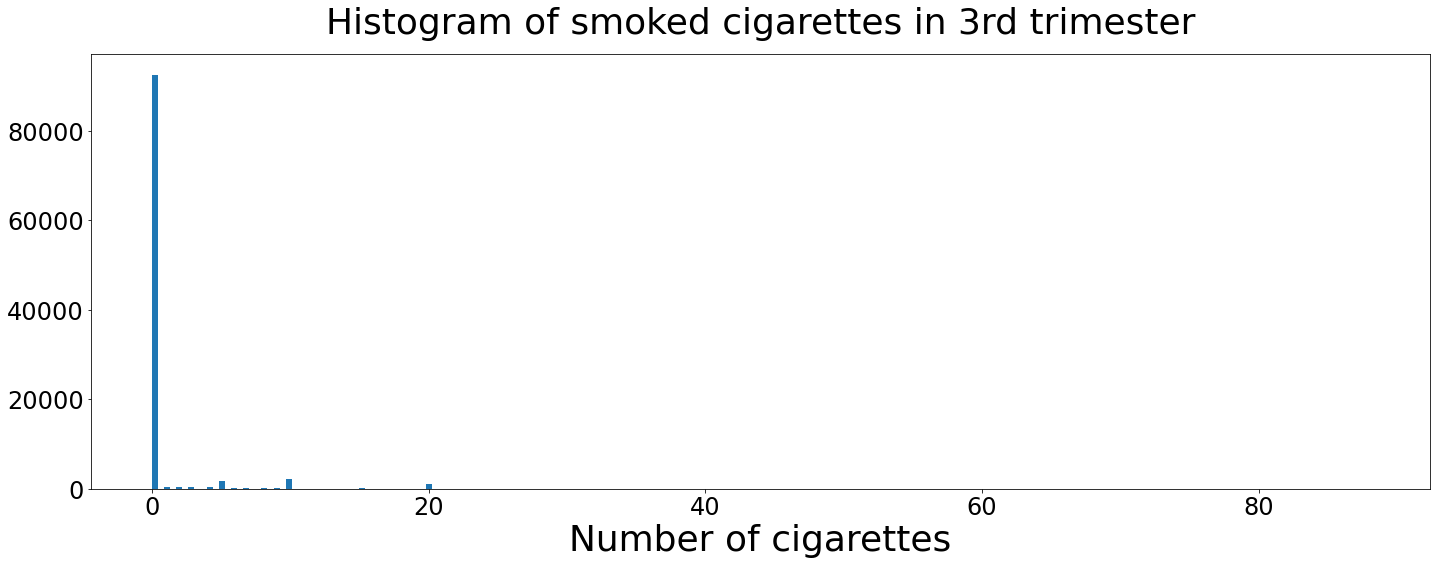

In [10]:
plt.figure(figsize=(24, 8))
plt.title("Histogram of smoked cigarettes in 3rd trimester", fontsize=36, pad=20)
plt.xlabel('Number of cigarettes', fontsize=36)
plt.hist(df['Cigarettes 3rd Trimester'], bins=200)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

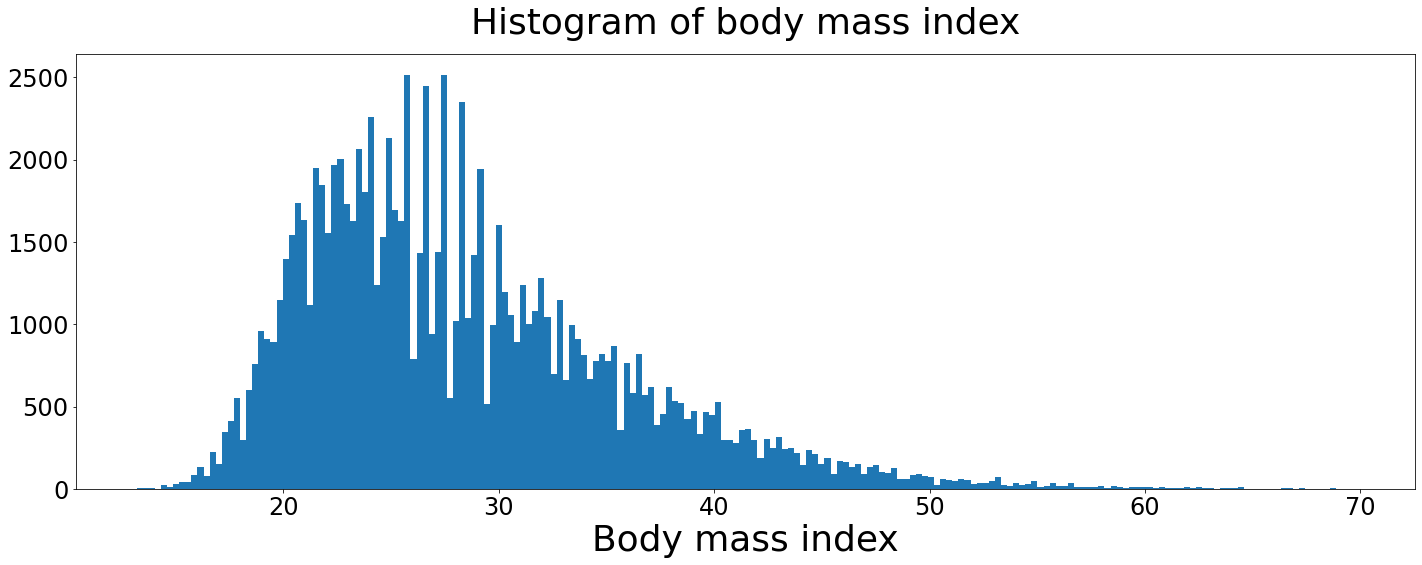

In [11]:
plt.figure(figsize=(24, 8))
plt.title("Histogram of body mass index", fontsize=36, pad=20)
plt.xlabel('Body mass index', fontsize=36)
plt.hist(df['Body Mass Index'], bins=200)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

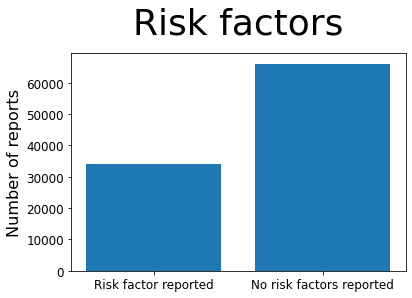

In [12]:
plt.title("Risk factors", fontsize=36, pad=20)
plt.bar(['Risk factor reported', 'No risk factors reported'], df['No Risk Factors Reported'].value_counts().sort_index())
plt.ylabel("Number of reports", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

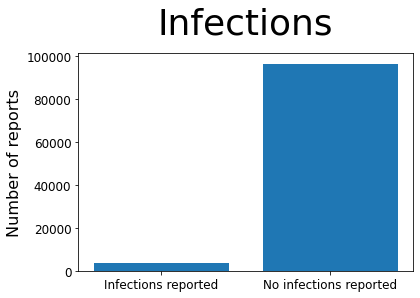

In [13]:
plt.title("Infections", fontsize=36, pad=20)
plt.bar(['Infections reported', 'No infections reported'], df['No Infections Reported'].value_counts().sort_index())
plt.ylabel("Number of reports", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

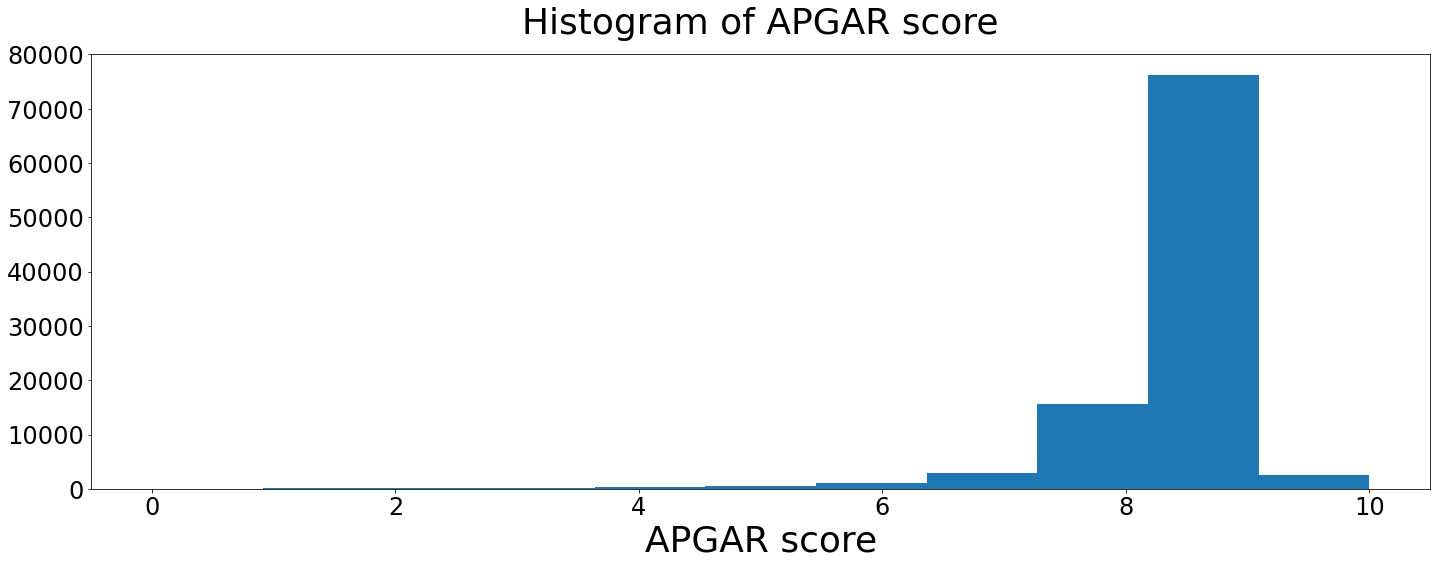

In [14]:
plt.figure(figsize=(24, 8))
plt.title("Histogram of APGAR score", fontsize=36, pad=20)
plt.xlabel('APGAR score', fontsize=36)
plt.hist(df['Five Minute APGAR Score'], bins=11)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [15]:
df['Five Minute APGAR Score'].value_counts()

9     76279
8     15602
7      2946
10     2557
6      1142
5       581
4       320
3       231
1       157
2       156
0        29
Name: Five Minute APGAR Score, dtype: int64

Możemy zauważyć bardzo mocne skrajności w naszym zestawie danych:
1. Mało kobiet pali w ciąży i przed nią
2. Bardzo mało kobiet ma infekcje w czasie ciąży
3. Większość urodzonych dzieci ma wynik APGAR w przedziela 8-10 (90% dzieci)

Są też dane, które są o wiele mniej skrajne:
1. Histogram wieku matek ma kształt rozkładu normalnego
2. BMI też ma kształt rozkładu normalnego.
3. 1/3 kobiet w ciąży była obarczona jakimś ryzykiem w czasie ciąży

Przeprowadzimy więc następujące modyfikacje zanim przejdziemy do bardziej szczegółówej analizy danych:
1. Nie uwzględnimy kolumny mówiących ile kobieta paliła przed ciążą
2. Połączymy wszystkie 3 kolumny mówiące o paleniu w ciąży i utworzymy z niej jedną kolumnę mówiącą czy kobieta paliła w ciąży czy nie
3. Nie uwzględnimy kolumny mówiącej o infekcjach w ciąży
4. Podzielimy wynika APGAR w następujące kategorie (Dobry - wynik APGAR od 8 do 10 i zły - wynik APGAR od 0 do 7)

### Konwersja zbioru danych

In [16]:
df.head()

,Mothers Single Years of Age,Mothers Age Recode 9,Cigarettes Before Pregnancy,Cigarettes 1st Trimester,Cigarettes 2nd Trimester,Cigarettes 3rd Trimester,Body Mass Index,Body Mass Index Recode,No Risk Factors Reported,No Infections Reported,Five Minute APGAR Score,Five Minute APGAR Recode
0,25,4,0,0,0,0,26.5,3,1,1,8,3
1,28,4,0,0,0,0,24.0,2,0,1,10,4
2,36,6,0,0,0,0,31.6,4,1,1,9,4
3,32,5,0,0,0,0,24.0,2,1,1,9,4
4,39,6,0,0,0,0,23.8,2,0,0,9,4


In [17]:
def is_smoking_during_pregnancy(cig_1st, cig_2nd, cig_3rd):
    return int(sum([cig_1st, cig_2nd, cig_3rd]) > 0)
    
df['Smoked during pregnancy'] = df.apply(lambda x: is_smoking_during_pregnancy(x['Cigarettes 1st Trimester'], x['Cigarettes 2nd Trimester'], x['Cigarettes 3rd Trimester']), axis=1)
df.head()

,Mothers Single Years of Age,Mothers Age Recode 9,Cigarettes Before Pregnancy,Cigarettes 1st Trimester,Cigarettes 2nd Trimester,Cigarettes 3rd Trimester,Body Mass Index,Body Mass Index Recode,No Risk Factors Reported,No Infections Reported,Five Minute APGAR Score,Five Minute APGAR Recode,Smoked during pregnancy
0,25,4,0,0,0,0,26.5,3,1,1,8,3,0
1,28,4,0,0,0,0,24.0,2,0,1,10,4,0
2,36,6,0,0,0,0,31.6,4,1,1,9,4,0
3,32,5,0,0,0,0,24.0,2,1,1,9,4,0
4,39,6,0,0,0,0,23.8,2,0,0,9,4,0


In [18]:
def is_apgar_score_good(apgar_score):
    return int(apgar_score >= 7)

df['APGAR score'] = df['Five Minute APGAR Score'].map(lambda x: is_apgar_score_good(x))
df.head()

,Mothers Single Years of Age,Mothers Age Recode 9,Cigarettes Before Pregnancy,Cigarettes 1st Trimester,Cigarettes 2nd Trimester,Cigarettes 3rd Trimester,Body Mass Index,Body Mass Index Recode,No Risk Factors Reported,No Infections Reported,Five Minute APGAR Score,Five Minute APGAR Recode,Smoked during pregnancy,APGAR score
0,25,4,0,0,0,0,26.5,3,1,1,8,3,0,1
1,28,4,0,0,0,0,24.0,2,0,1,10,4,0,1
2,36,6,0,0,0,0,31.6,4,1,1,9,4,0,1
3,32,5,0,0,0,0,24.0,2,1,1,9,4,0,1
4,39,6,0,0,0,0,23.8,2,0,0,9,4,0,1


In [19]:
df.drop(['Cigarettes Before Pregnancy', 'Cigarettes 1st Trimester', 'Cigarettes 2nd Trimester', 'Cigarettes 3rd Trimester', 'No Infections Reported', 'Five Minute APGAR Score', 'Five Minute APGAR Recode'], axis=1, inplace=True)
df.head()

,Mothers Single Years of Age,Mothers Age Recode 9,Body Mass Index,Body Mass Index Recode,No Risk Factors Reported,Smoked during pregnancy,APGAR score
0,25,4,26.5,3,1,0,1
1,28,4,24.0,2,0,0,1
2,36,6,31.6,4,1,0,1
3,32,5,24.0,2,1,0,1
4,39,6,23.8,2,0,0,1


### EDA

In [20]:
def get_mothers_age_description(age_recode):
    if age_recode == 1:
        return 'Under 15'
    elif age_recode == 2:
        return '15-19'
    elif age_recode == 3:
        return '20-24'
    elif age_recode == 4:
        return '25-29'
    elif age_recode == 5:
        return '30-34'
    elif age_recode == 6:
        return '35-39'
    elif age_recode == 7:
        return '40-44'
    elif age_recode == 8:
        return '45-49'
    elif age_recode == 9:
        return '50-54'
    else:
        return 'ERROR'
    
def get_body_mass_description(body_mass_recode):
    if body_mass_recode == 1:
        return 'Underweight'
    elif body_mass_recode == 2:
        return 'Normal'
    elif body_mass_recode == 3:
        return "Overweight"
    elif body_mass_recode == 4:
        return "Obesity I"
    elif body_mass_recode == 5:
        return "Obesity II"
    elif body_mass_recode == 6:
        return "Extreme Obesity III"
    else:
        return "ERROR"
    
df['Mothers age description'] = df['Mothers Age Recode 9'].map(lambda x: get_mothers_age_description(x))
df['Body mass index description'] = df['Body Mass Index Recode'].map(lambda x: get_body_mass_description(x))
df['No Risk Factors Reported description'] = df['No Risk Factors Reported'].map(lambda x: "No risk factors reported" if x==1 else "Risk factors reported")
df['Smoking during pregnancy description'] = df['Smoked during pregnancy'].map(lambda x: "Smoked during pregnancy" if x==1 else "Didn't smoke during pregnancy")
df['APGAR score description'] = df['APGAR score'].map(lambda x: "Good" if x==1 else "Bad")
df.head()

,Mothers Single Years of Age,Mothers Age Recode 9,Body Mass Index,Body Mass Index Recode,No Risk Factors Reported,Smoked during pregnancy,APGAR score,Mothers age description,Body mass index description,No Risk Factors Reported description,Smoking during pregnancy description,APGAR score description
0,25,4,26.5,3,1,0,1,25-29,Overweight,No risk factors reported,Didn't smoke during pregnancy,Good
1,28,4,24.0,2,0,0,1,25-29,Normal,Risk factors reported,Didn't smoke during pregnancy,Good
2,36,6,31.6,4,1,0,1,35-39,Obesity I,No risk factors reported,Didn't smoke during pregnancy,Good
3,32,5,24.0,2,1,0,1,30-34,Normal,No risk factors reported,Didn't smoke during pregnancy,Good
4,39,6,23.8,2,0,0,1,35-39,Normal,Risk factors reported,Didn't smoke during pregnancy,Good


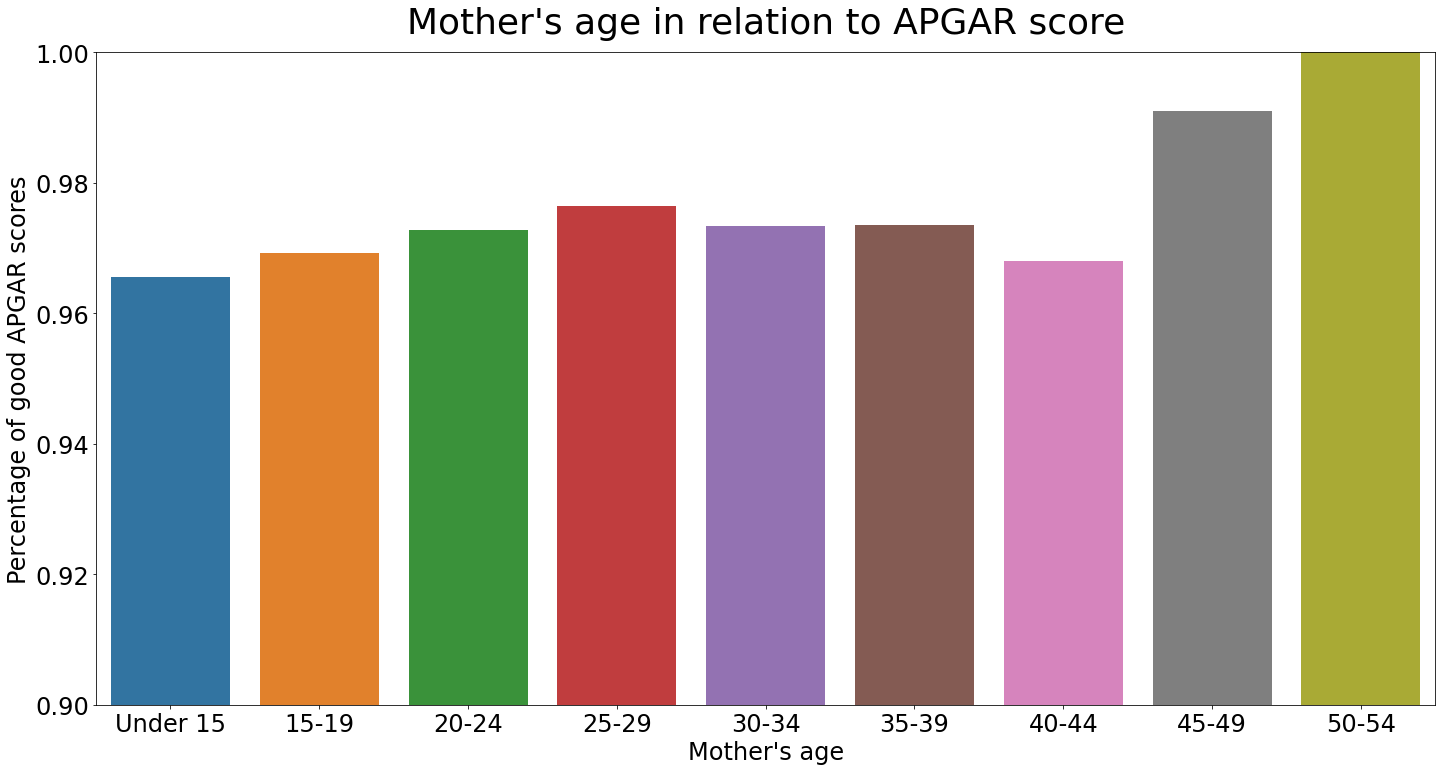

In [21]:
plt.figure(figsize=(24, 12))
sns.barplot(x='Mothers age description', y='APGAR score', data=df.sort_values('Mothers Age Recode 9'), ci=None)
plt.title("Mother's age in relation to APGAR score", fontsize=36, y=1.02)
plt.xlabel("Mother's age", fontsize=24)
plt.ylabel("Percentage of good APGAR scores", fontsize=24, x=0.7)
plt.ylim(0.9, 1)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

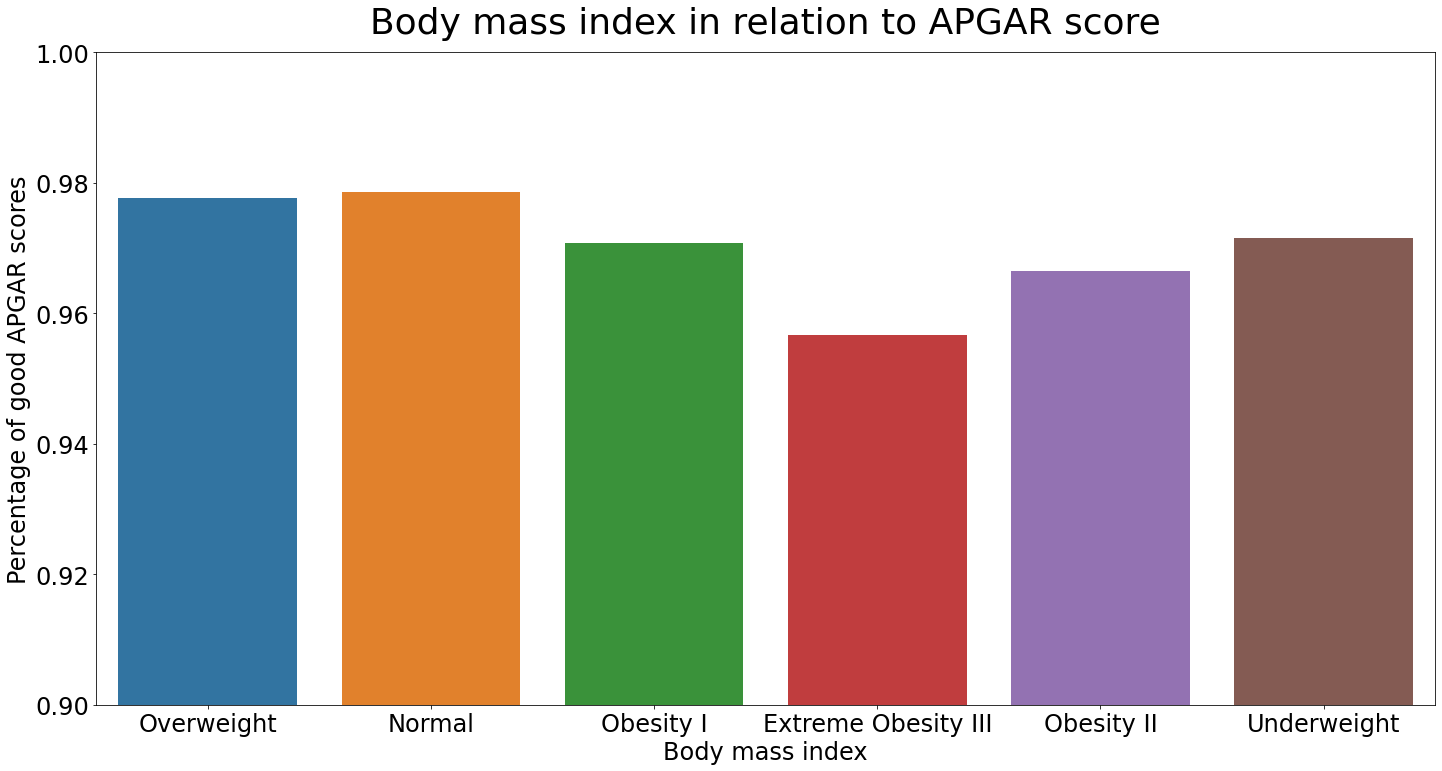

In [22]:
plt.figure(figsize=(24, 12))
sns.barplot(x='Body mass index description', y='APGAR score', data=df, ci=None)
plt.title("Body mass index in relation to APGAR score", fontsize=36, y=1.02)
plt.xlabel("Body mass index", fontsize=24)
plt.ylabel("Percentage of good APGAR scores", fontsize=24)
plt.ylim(0.9, 1)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

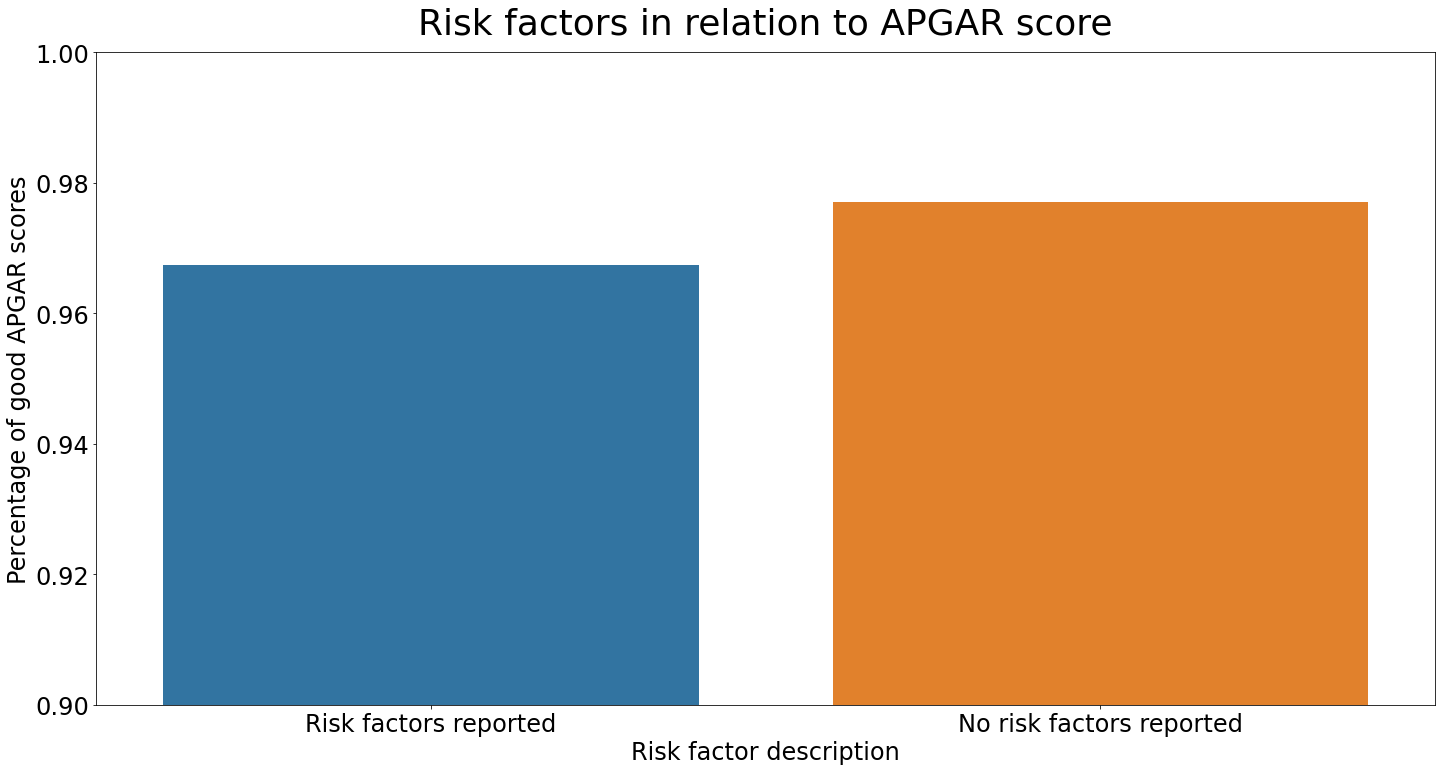

In [23]:
plt.figure(figsize=(24, 12))
sns.barplot(x='No Risk Factors Reported description', y='APGAR score', data=df.sort_values('No Risk Factors Reported'), ci=None)
plt.title("Risk factors in relation to APGAR score", fontsize=36, y=1.02)
plt.xlabel("Risk factor description", fontsize=24)
plt.ylabel("Percentage of good APGAR scores", fontsize=24)
plt.ylim(0.9, 1)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

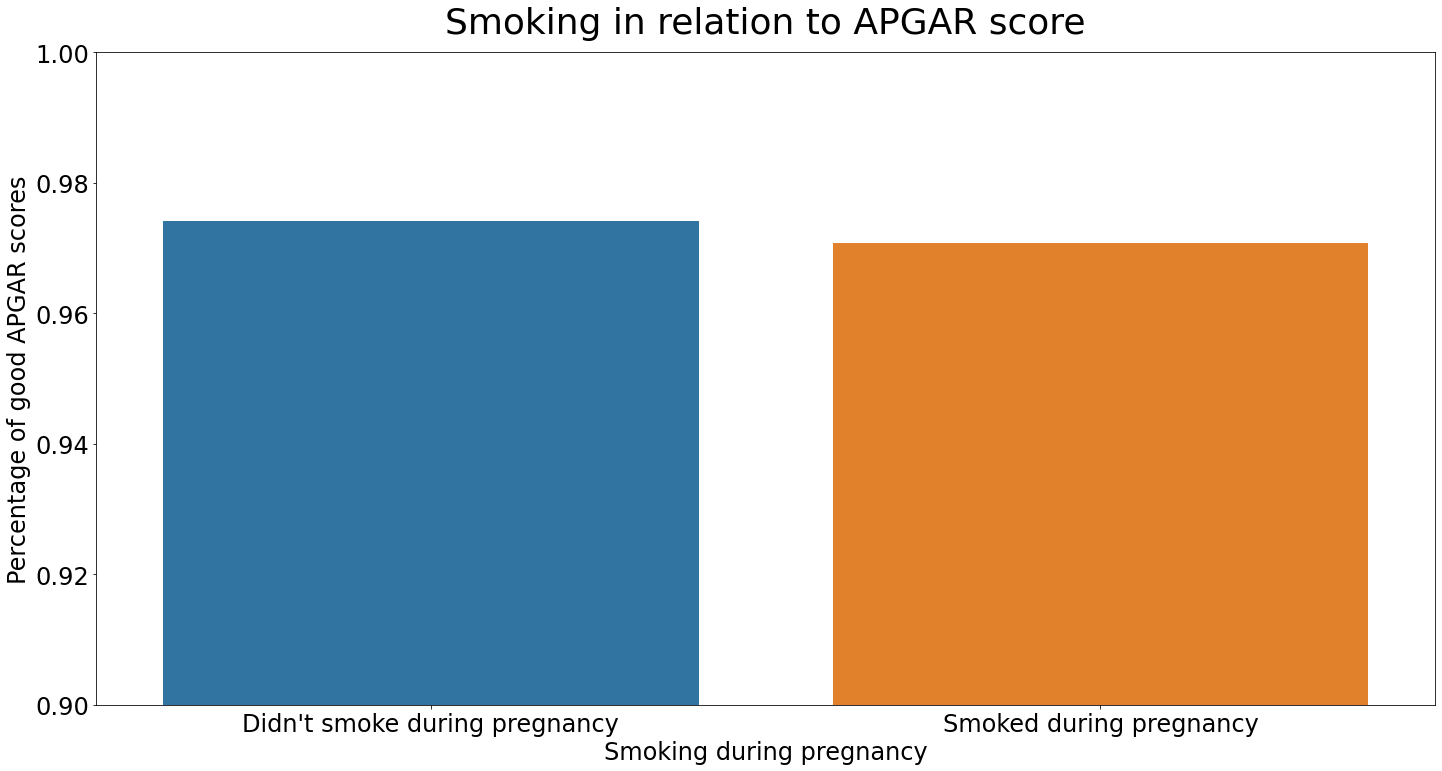

In [24]:
plt.figure(figsize=(24, 12))
sns.barplot(x='Smoking during pregnancy description', y='APGAR score', data=df.sort_values('Smoked during pregnancy'), ci=None)
plt.title("Smoking in relation to APGAR score", fontsize=36, y=1.02)
plt.xlabel("Smoking during pregnancy", fontsize=24)
plt.ylabel("Percentage of good APGAR scores", fontsize=24)
plt.ylim(0.9, 1)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

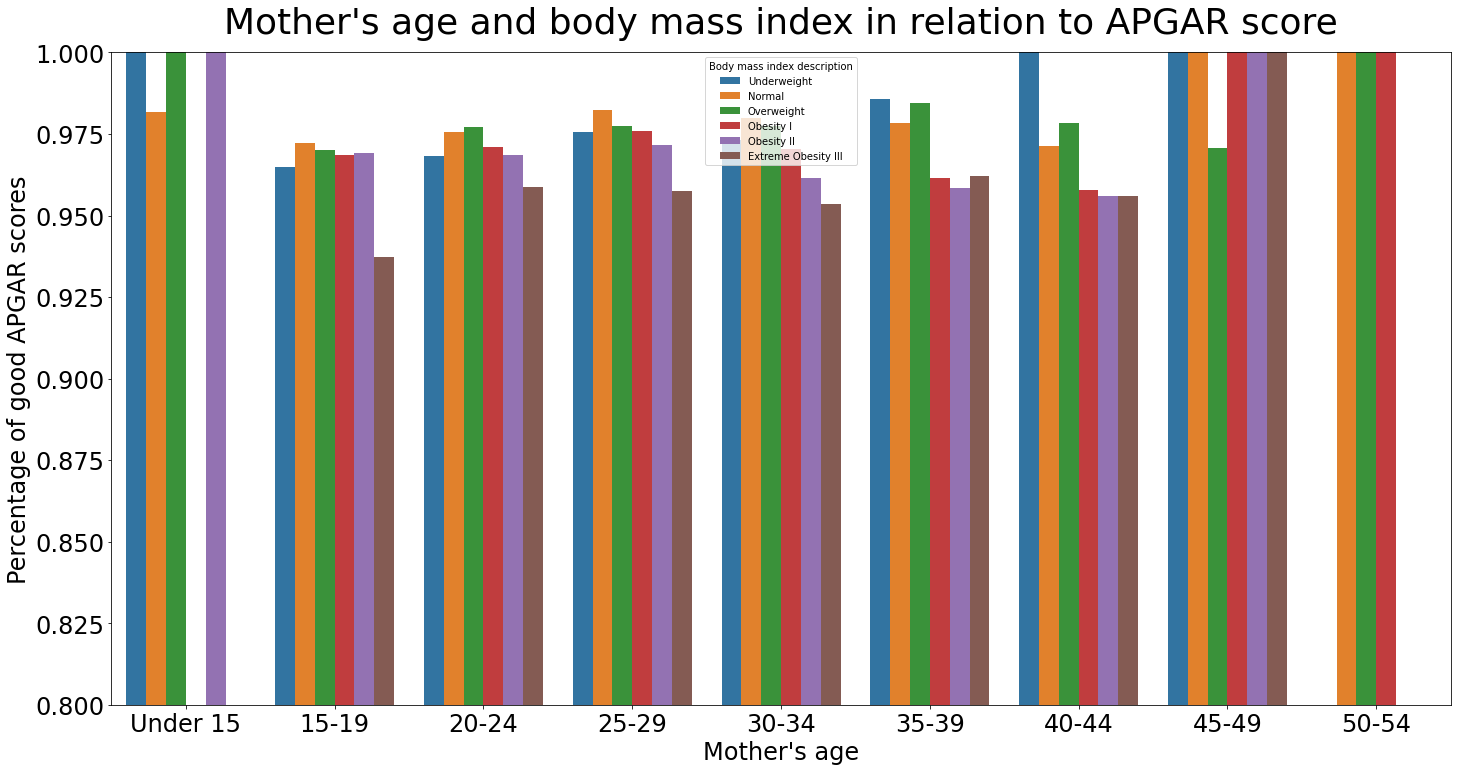

In [25]:
plt.figure(figsize=(24, 12))
sns.barplot(x='Mothers age description', y='APGAR score', hue='Body mass index description', data=df.sort_values(['Mothers Age Recode 9', 'Body Mass Index Recode']), ci=None)
plt.title("Mother's age and body mass index in relation to APGAR score", fontsize=36, y=1.02)
plt.xlabel("Mother's age", fontsize=24)
plt.ylabel("Percentage of good APGAR scores", fontsize=24)
plt.ylim(0.8, 1)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

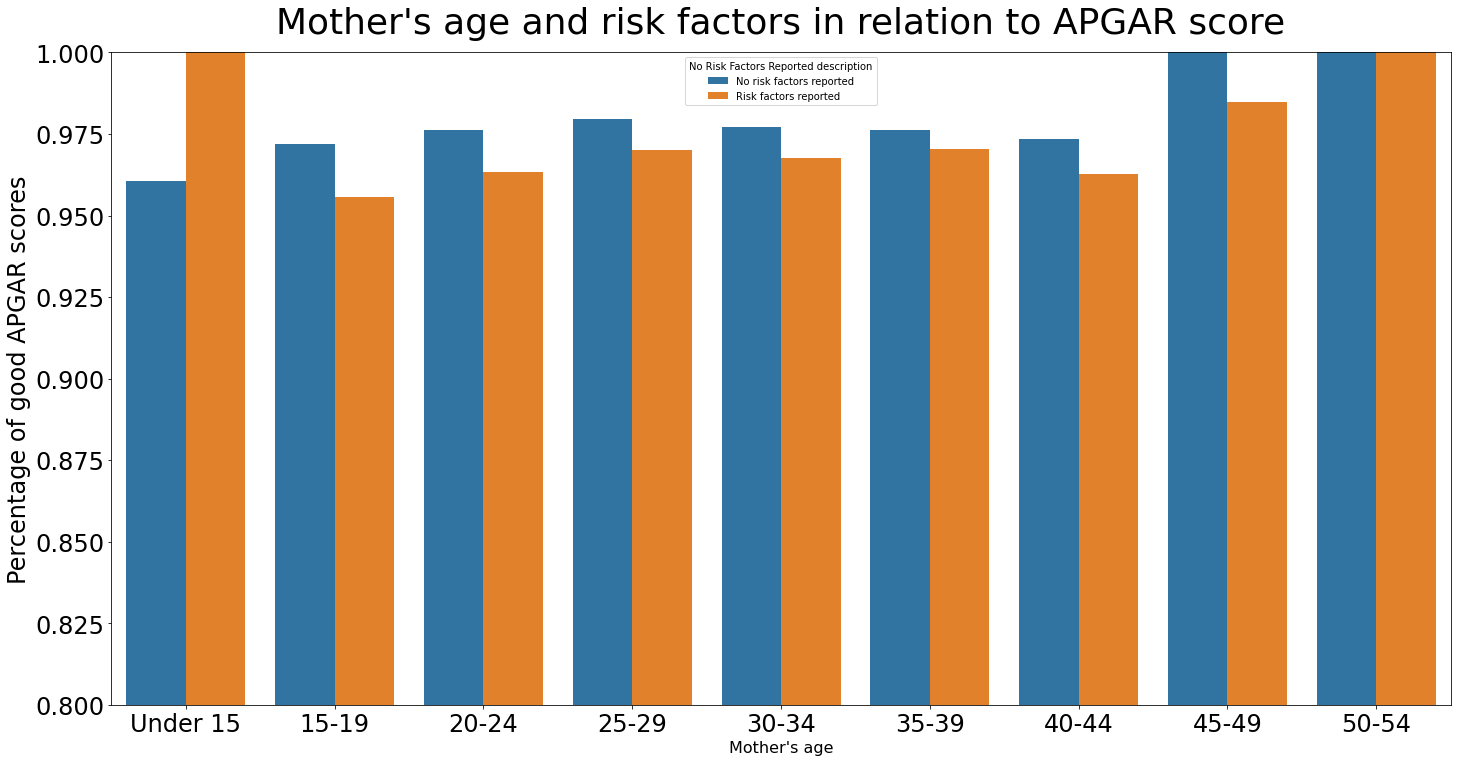

In [26]:
plt.figure(figsize=(24, 12))
sns.barplot(x='Mothers age description', y='APGAR score', hue='No Risk Factors Reported description', data=df.sort_values(['Mothers Age Recode 9', 'Body Mass Index Recode']), ci=None)
plt.title("Mother's age and risk factors in relation to APGAR score", fontsize=36, y=1.02)
plt.xlabel("Mother's age", fontsize=16)
plt.ylabel("Percentage of good APGAR scores", fontsize=24)
plt.ylim(0.8, 1)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

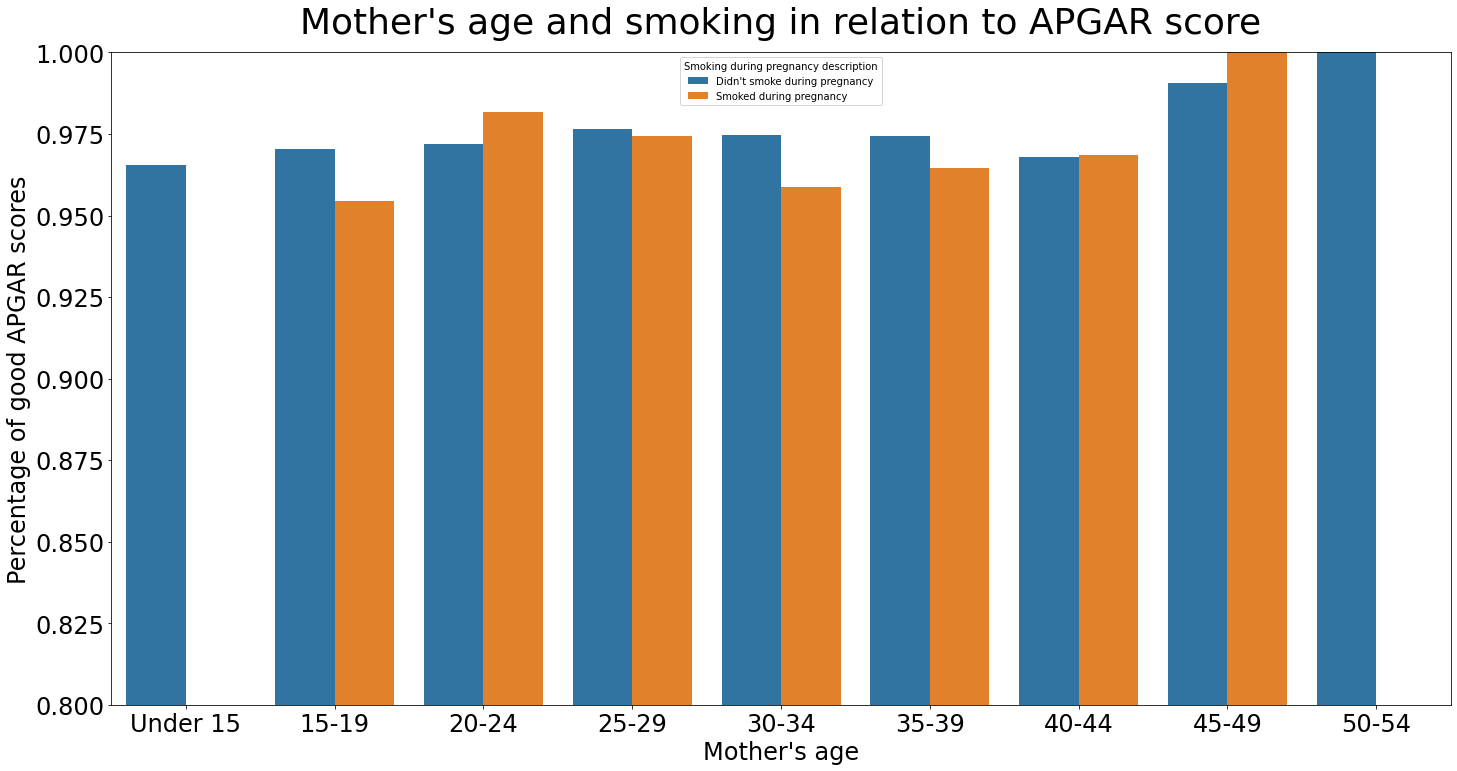

In [27]:
plt.figure(figsize=(24, 12))
sns.barplot(x='Mothers age description', y='APGAR score', hue='Smoking during pregnancy description', data=df.sort_values(['Mothers Age Recode 9', 'Smoked during pregnancy']), ci=None)
plt.title("Mother's age and smoking in relation to APGAR score", fontsize=36, y=1.02)
plt.xlabel("Mother's age", fontsize=24)
plt.ylabel("Percentage of good APGAR scores", fontsize=24)
plt.ylim(0.8, 1)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

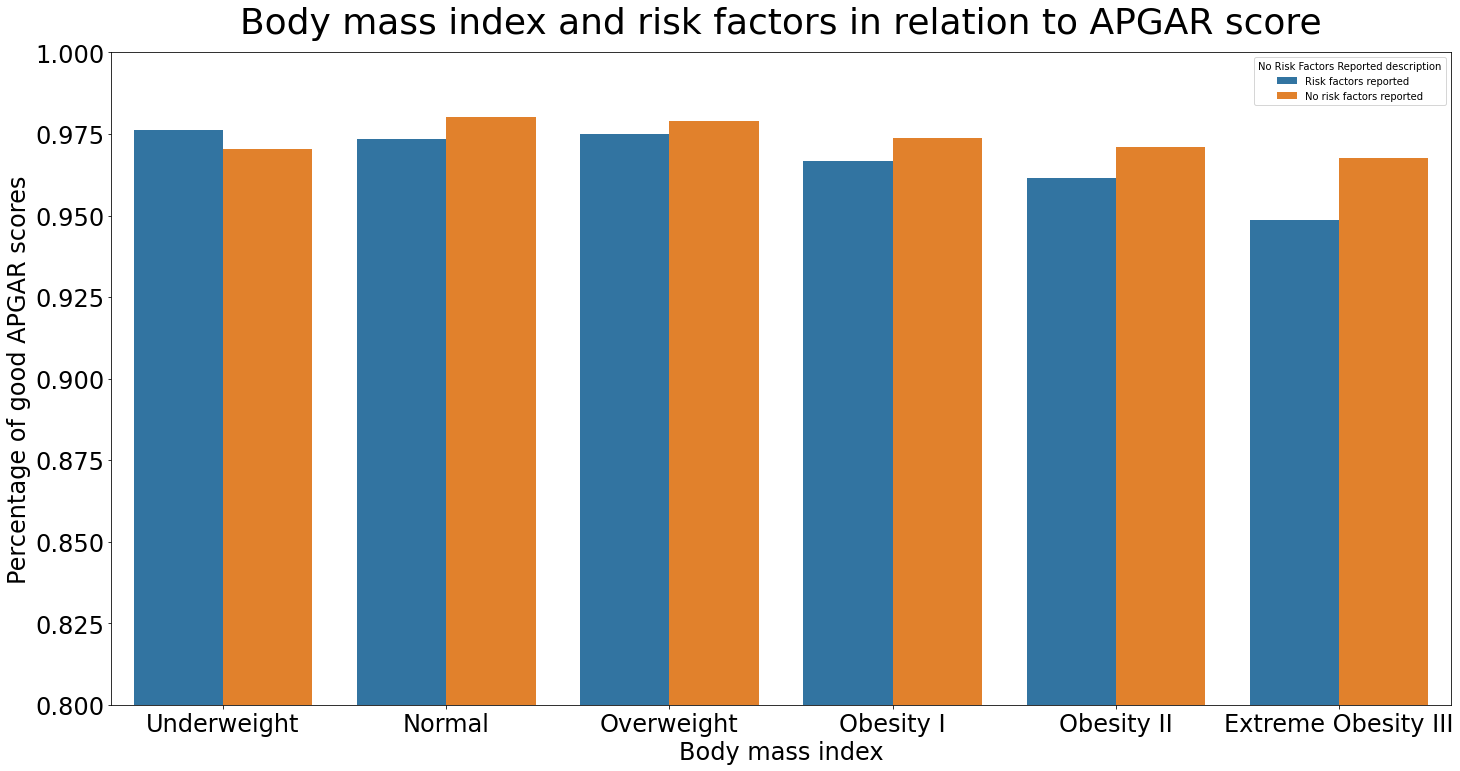

In [28]:
plt.figure(figsize=(24, 12))
sns.barplot(x='Body mass index description', y='APGAR score', hue='No Risk Factors Reported description', data=df.sort_values(['Body Mass Index Recode', 'No Risk Factors Reported']), ci=None)
plt.title("Body mass index and risk factors in relation to APGAR score", fontsize=36, y=1.02)
plt.xlabel("Body mass index", fontsize=24)
plt.ylabel("Percentage of good APGAR scores", fontsize=24)
plt.ylim(0.8, 1)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

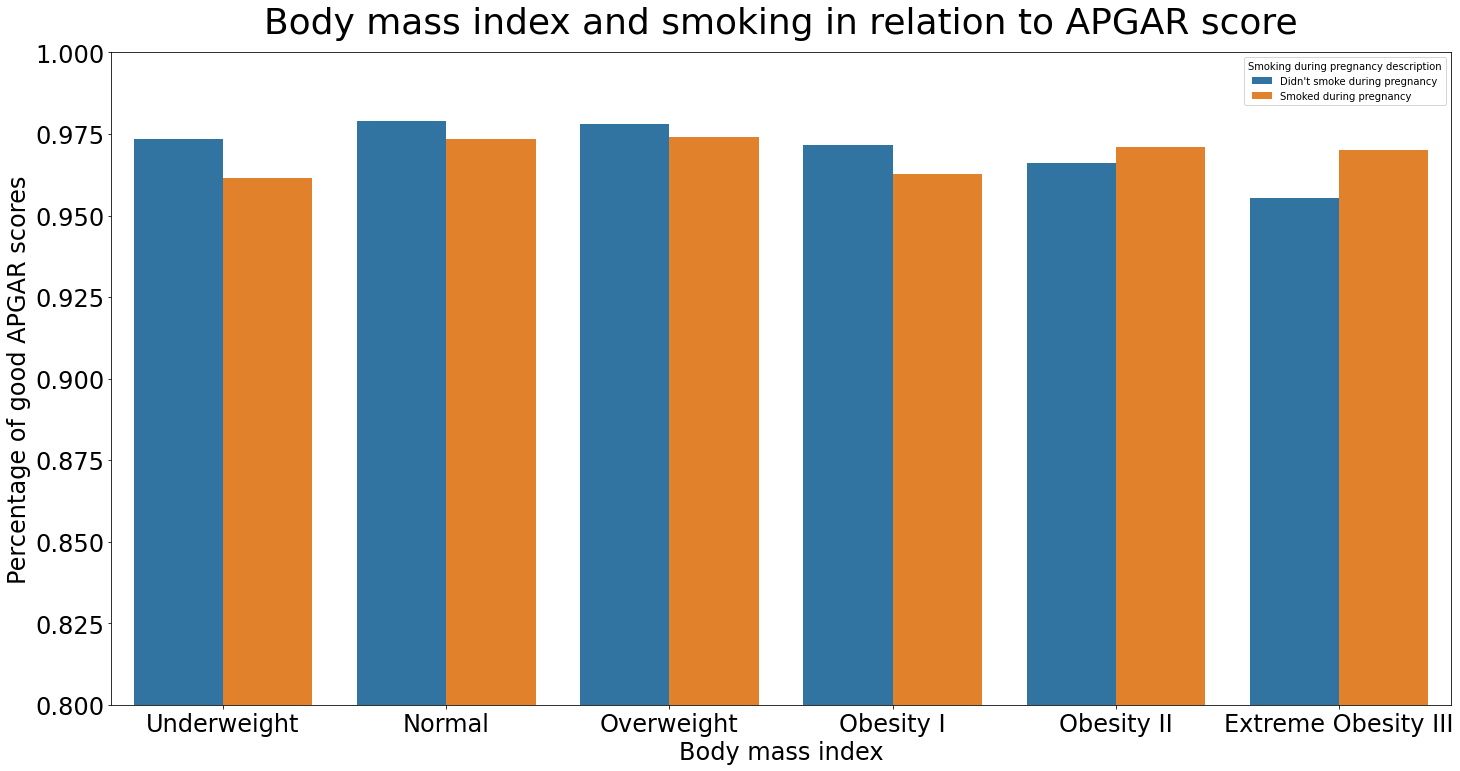

In [29]:
plt.figure(figsize=(24, 12))
sns.barplot(x='Body mass index description', y='APGAR score', hue='Smoking during pregnancy description', data=df.sort_values(['Body Mass Index Recode', 'Smoked during pregnancy']), ci=None)
plt.title("Body mass index and smoking in relation to APGAR score", fontsize=36, y=1.02)
plt.xlabel("Body mass index", fontsize=24)
plt.ylabel("Percentage of good APGAR scores", fontsize=24)
plt.ylim(0.8, 1)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

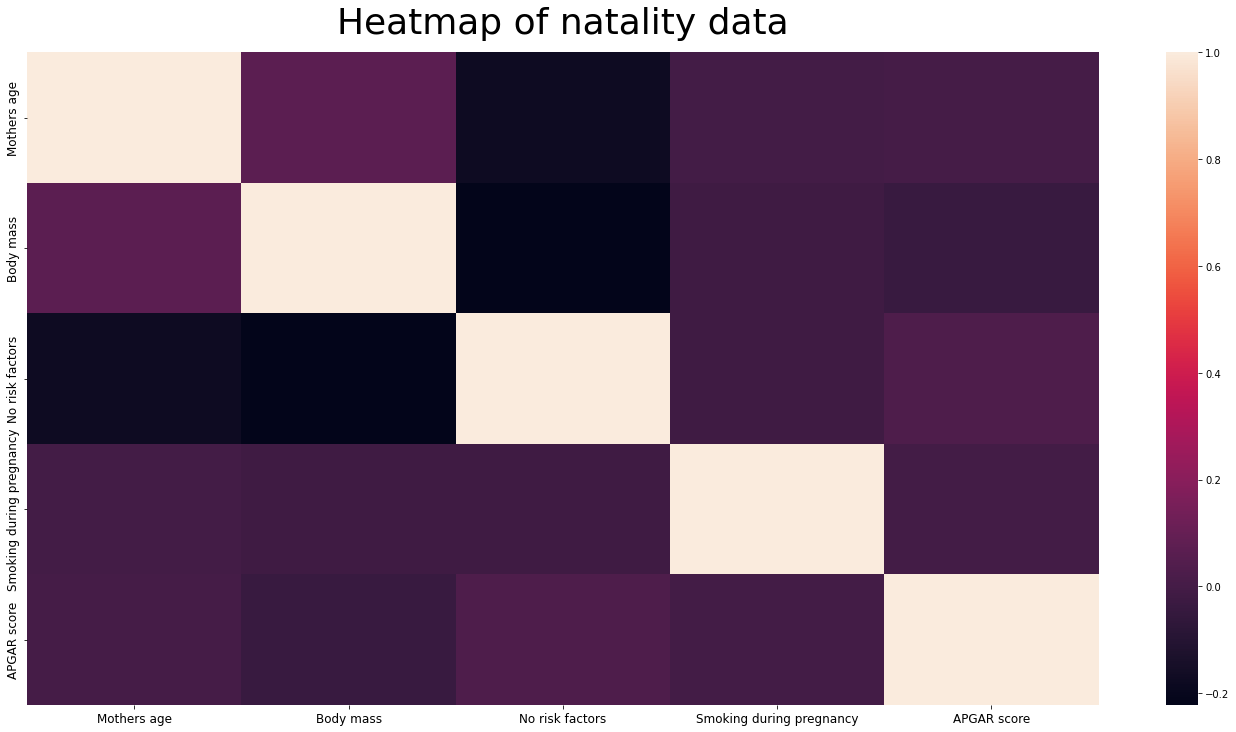

In [30]:
df_corr = df[['Mothers Age Recode 9', 'Body Mass Index Recode', 'No Risk Factors Reported', 'Smoked during pregnancy', 'APGAR score']].corr()
axis_labels = ["Mothers age", "Body mass", "No risk factors", "Smoking during pregnancy", "APGAR score"]

plt.figure(figsize=(24, 12))
sns.heatmap(df_corr, xticklabels=axis_labels, yticklabels=axis_labels)
plt.title("Heatmap of natality data", fontsize=36, y=1.02)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Możemy wyciągnąć kilka wniosków z powyższych wykresów
1. Kobiety poniżej 15 i powyżej 44 lat są obserwacjami odstającymi. Jako, że ilość danych z tych grup wiekowych nie jest reprezentatywna wykluczymy z dalszej analizy kobiety w jednym z podanych przedziałów wiekowych
2. Każdy z czynników (wiek, masa ciała, różne ryzyka powstałe w czasie ciąży i palenie podczas ciąży) ma mały wpływ na wynik APGAR

### Pozbycie się nieodpowiednich danych

In [31]:
df = df[(df['Mothers Age Recode 9'] != 1) & (df['Mothers Age Recode 9'] != 8) & (df['Mothers Age Recode 9'] != 9)]
df.head()

,Mothers Single Years of Age,Mothers Age Recode 9,Body Mass Index,Body Mass Index Recode,No Risk Factors Reported,Smoked during pregnancy,APGAR score,Mothers age description,Body mass index description,No Risk Factors Reported description,Smoking during pregnancy description,APGAR score description
0,25,4,26.5,3,1,0,1,25-29,Overweight,No risk factors reported,Didn't smoke during pregnancy,Good
1,28,4,24.0,2,0,0,1,25-29,Normal,Risk factors reported,Didn't smoke during pregnancy,Good
2,36,6,31.6,4,1,0,1,35-39,Obesity I,No risk factors reported,Didn't smoke during pregnancy,Good
3,32,5,24.0,2,1,0,1,30-34,Normal,No risk factors reported,Didn't smoke during pregnancy,Good
4,39,6,23.8,2,0,0,1,35-39,Normal,Risk factors reported,Didn't smoke during pregnancy,Good


### Konstrukcja modelu i predykcje
Do predykcji wyniku APGAR użyjemy regresji logistycznej. Będziemy ewaluować poprawność modelu za pomocą wyniku F1, macierzy błędów i innych metryk (np. accuracy, precision, recall)

In [32]:
X = df[['Mothers Age Recode 9', 'Body Mass Index Recode', 'No Risk Factors Reported', 'Smoked during pregnancy']]
y = df['APGAR score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [33]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [34]:
print(confusion_matrix(y_test, y_pred))

[[    0   665]
 [    0 24284]]


In [35]:
print(classification_report(y_test, y_pred, labels=np.unique(y_pred)))

              precision    recall  f1-score   support

           1       0.97      1.00      0.99     24284

   micro avg       0.97      1.00      0.99     24284
   macro avg       0.97      1.00      0.99     24284
weighted avg       0.97      1.00      0.99     24284



In [36]:
print(f1_score(y_test, y_pred))

0.9864927995450207


Możemy zauważyć, że model w żaden sposób nie dopasował się do danych. Zawsze przewiduje on dobry wynik APGAR. Prawdopodobnie wynika to z tego, że mamy bardzo mało przypadków niskiego wyniku APGAR i model overfittuje do dobrego wyniku APGAR. Postaramy się więc rozwiązać ten problem poprzez selektywny wybór danych do analizy (tak, żeby była równa dystrybucja niskich i wysokich wyników APGAR) 